In [551]:
import pandas
import os
import sys
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabaz_score, silhouette_score
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
import vogel_basc as vb

In [141]:
reload(vb)

<module 'vogel_basc' from '/home/users/jvogel/git/data_driven_pathology/vogel_basc.py'>

In [2]:
%matplotlib inline

In [3]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
bigdf = bigdf.values.T

In [4]:
# gdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/MAIN_gcx_wholebrain_info_W_DKT_label.csv')
# gdf.columns

In [4]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [2]:
bigdf = pandas.DataFrame(bigdf)
tr,te = train_test_split(bigdf, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z']]

In [ ]:
cca_mod = CCA()
cca_mod.fit(tr,tr_y)

In [6]:
plotr = pandas.concat([pandas.Series(cca_mod.predict(te)[:,0], index = te_y.index), 
                       pandas.Series(cca_mod.predict(te)[:,1], index = te_y.index), 
                       pandas.Series(te_y.loc[:,te_y.columns[0]]),
                       pandas.Series(te_y.loc[:,te_y.columns[1]]), 
                       gdf.loc[te_y.index,'slab_type']], 
                      axis=1)
plotr.columns = ['predicted_y', 'predicted_z', 'observed_y', 'observed_z', 'slab_type']

NameError: name 'cca_mod' is not defined

In [ ]:
#sns.set_context('paper')

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+2], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[(3-i)], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[1-i]]))

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+2], col = 'slab_type', data = plotr)
    plt.show()

In [ ]:
for i in range(2):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[(3-i)], col = 'slab_type', data = plotr)
    plt.show()

In [ ]:
probes = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/normalized_microarray_donor10021/Probes.csv')
dx = pandas.concat([pandas.Series(cca_mod.x_loadings_[:,0]),
                   pandas.Series(cca_mod.x_loadings_[:,0])],
                   axis=1)
dx.loc[:,'symbol'] = probes.loc[:,'gene_symbol'].values
dx.loc[:,'name'] = probes.loc[:,'gene_name'].values

## PCA FIRST

In [242]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.7799918958717118

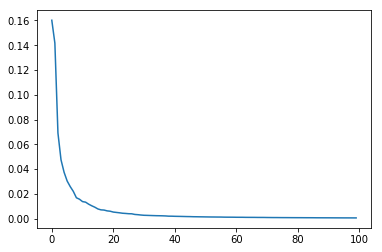

In [6]:
plt.plot(pcamod.explained_variance_ratio_)

In [243]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [35]:
#pca_tfm = pandas.DataFrame(np.load('/Users/jakevogel/Dropbox/McGill/Neur608/Final_Project/stuff/train_PCA.npz'
#                                  )['arr_0'])

In [55]:
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z']]

PERFORM KFOLD CV TO FIGURE OUT NUMBER OF COMPONENTS

In [41]:
from sklearn.cross_decomposition import PLSCanonical, PLSSVD

In [53]:
nc_chooser.loc[k*3:k*3+3]

,nc,estimator,r2,mae
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


In [58]:
ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, tr, tr_y, 
                                groups = gdf.loc[tr.index].slab_type, cv=10)
        nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

1
2
3


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

4


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

6


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

7


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

8


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

9


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

10


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at i

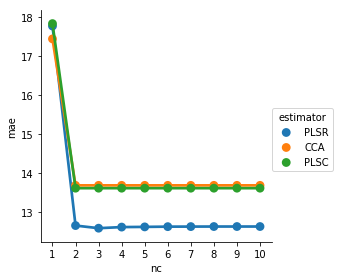

In [59]:
sns.factorplot(x = 'nc', y='mae', hue = 'estimator', data=nc_chooser)

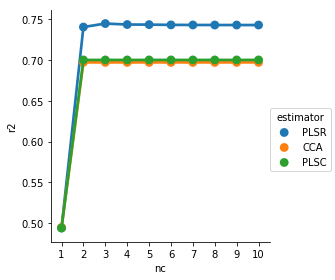

In [60]:
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)

Fit the PLSR model

In [9]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

evaluate model

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


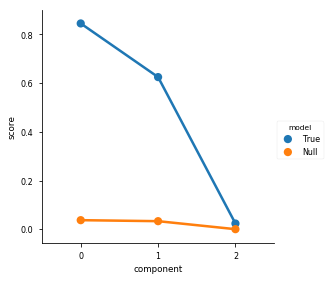

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***


In [12]:
# significant components?
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)

In [13]:
comp_sig

,p,sig
0,0.002,1
1,0.002,1
2,0.002,1


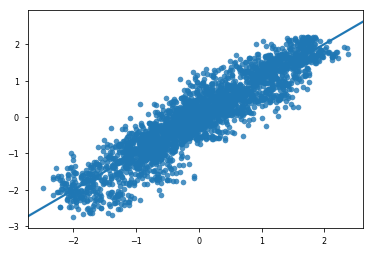

r2 = 0.845294923067, percent of total = 0.845294923067


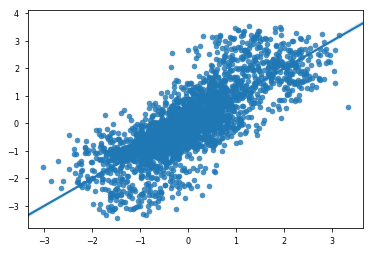

r2 = 0.624978064963, percent of total = 0.0966872796213


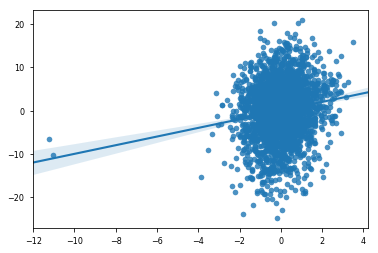

r2 = 0.0236249291993, percent of total = -0.0111101660466


In [88]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

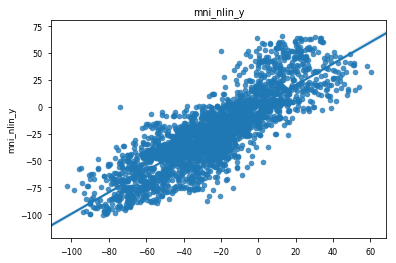

(0.84152652806162342, 0.0)
13.5916186894


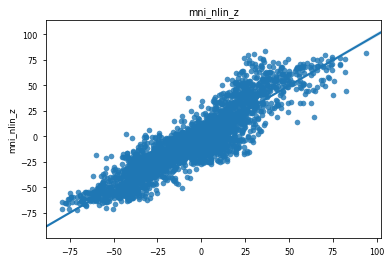

(0.89905582593927091, 0.0)
10.8844532271


In [56]:
# plot model fit
pred = pls_mod.predict(tr)
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], tr_y[tr_y.columns[i]])
    plt.title(tr_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]]))

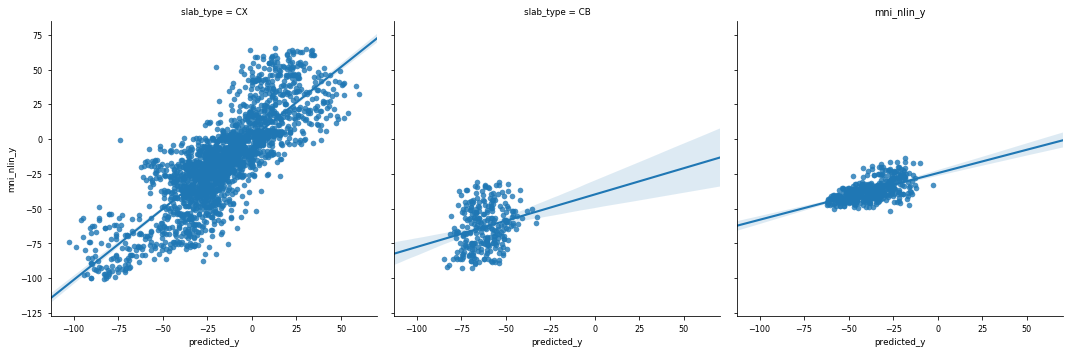

CX r2 =0.666370628414
CX mae =14.7850888396
CB r2 =0.0555817688552
CB mae =13.7831523232
BS r2 =0.305272185255
BS mae =7.9328614761


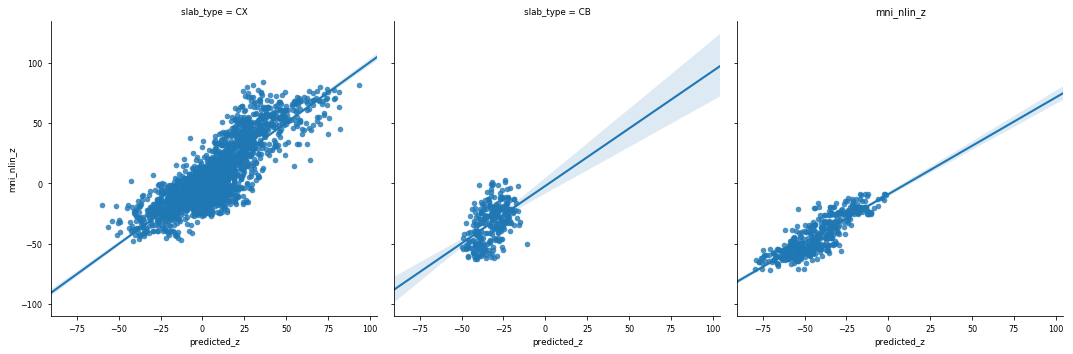

CX r2 =0.698902391389
CX mae =11.5423996094
CB r2 =0.225261343767
CB mae =11.5548222563
BS r2 =0.70399622488
BS mae =7.41169931522


In [57]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z'] + tr_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[tr.index,'slab_type']
for i in range(tr_y.shape[-1]):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+2], col = 'slab_type', data = preds_df)
    plt.title(preds_df.columns[i+2])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

## Compare to test set

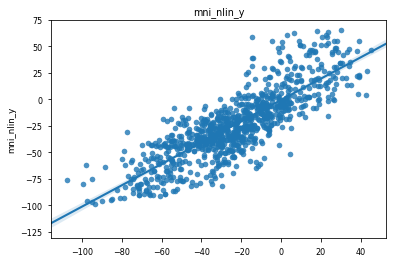

(0.8295033867078303, 5.6309575681050324e-236)
14.0657083154


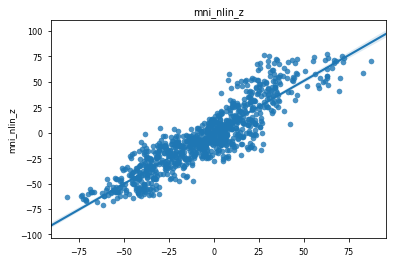

(0.89553409898549341, 0.0)
11.2391898356


In [115]:
# plot model fit
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))

## fit on entire dataset

In [244]:
pls_mod = PLSRegression(n_components=3)
full_y = gdf[['mni_nlin_y','mni_nlin_z']]
pls_mod.fit(pca_tfm, full_y)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


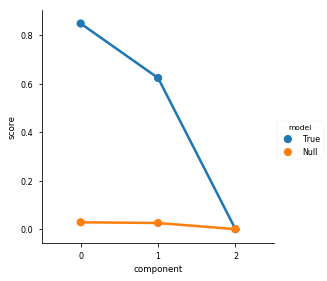

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***


In [66]:
# significant components?
results, comp_sig = evaluate_components(pls_mod, pca_tfm, full_y)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


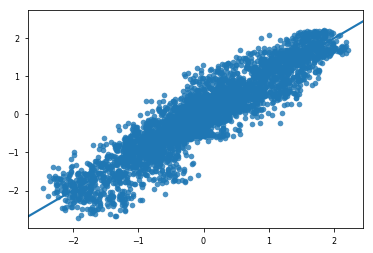

r2 = 0.848120882754, percent of total = 0.848120882754


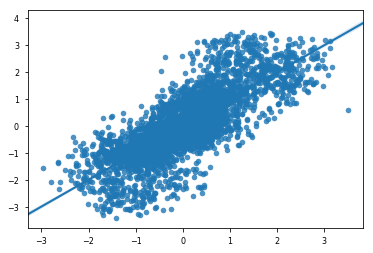

r2 = 0.623467002733, percent of total = 0.0946916180069


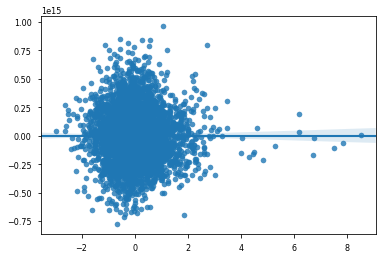

r2 = 1.50748146474e-29, percent of total = -7.10909996369e-30


In [53]:
pls_mod.fit(pca_tfm, gdf[['mni_nlin_y','mni_nlin_z']])
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    plt.show()
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

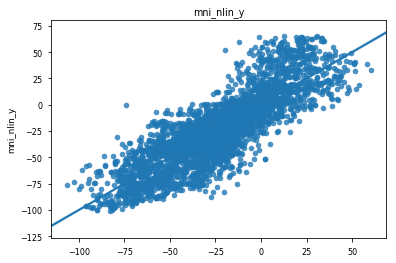

(0.84005125959020388, 0.0)
13.6542368801


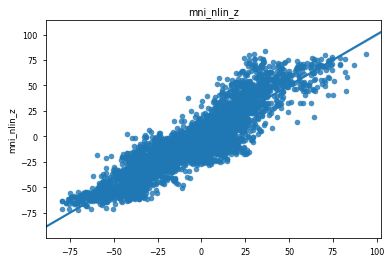

(0.89955309522859672, 0.0)
10.8922981139


In [69]:
# plot model fit
pred = pls_mod.predict(pca_tfm)
for i in range(full_y.shape[-1]):
    plt.close()
    sns.regplot(pred[:,i], full_y[full_y.columns[i]])
    plt.title(full_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], full_y[full_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], full_y[full_y.columns[i]]))

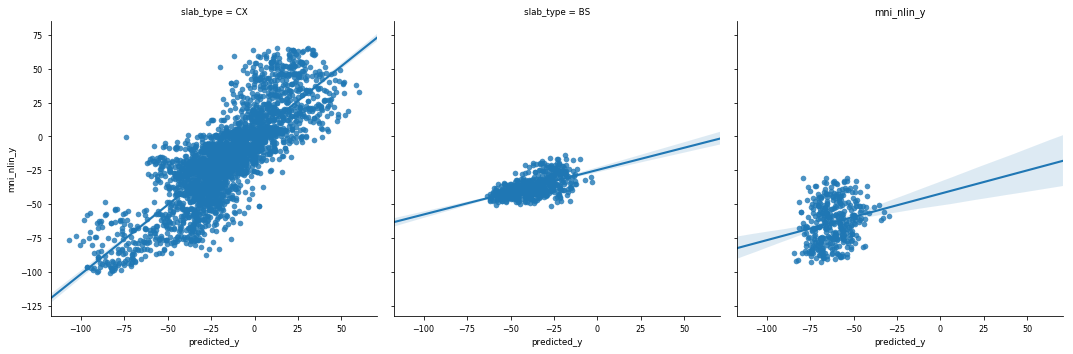

CX r2 =0.66353527872
CX mae =14.8462976513
BS r2 =0.294286845575
BS mae =7.89403590976
CB r2 =0.0462030037215
CB mae =13.92514658


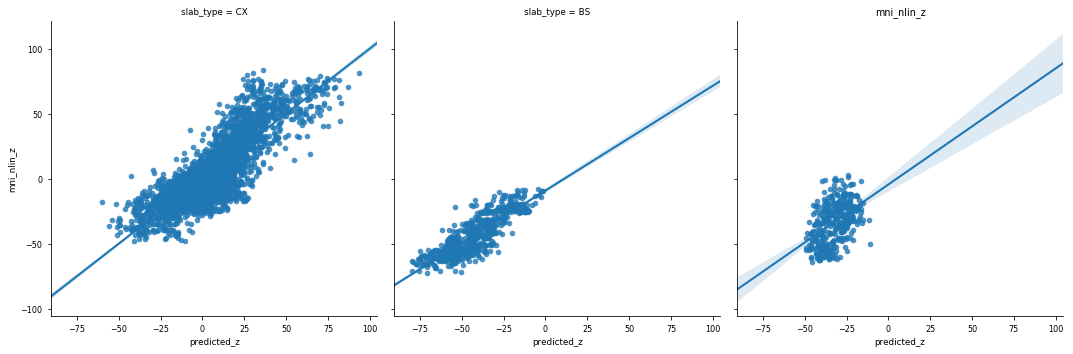

CX r2 =0.699690286854
CX mae =11.530820616
BS r2 =0.705694635128
BS mae =7.29359733066
CB r2 =0.206729809891
CB mae =11.8547405681


In [70]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = gdf.loc[pca_tfm.index,'slab_type']
for i in range(full_y.shape[-1]):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+2], col = 'slab_type', data = preds_df)
    plt.title(preds_df.columns[i+2])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [71]:
preds_df.shape

(3702, 5)

In [72]:
preds_df.loc[:,'structure'] = gdf.structure_acronym.values

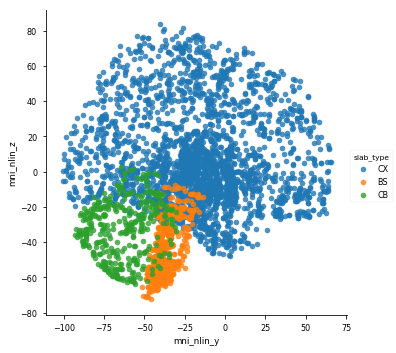

In [25]:
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'slab_type', data=gdf, fit_reg=False)

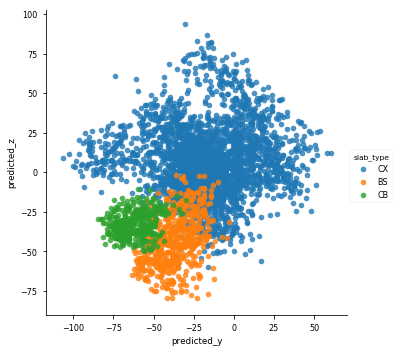

In [73]:
sns.lmplot('predicted_y', 'predicted_z', hue = 'slab_type', data=preds_df, fit_reg=False)

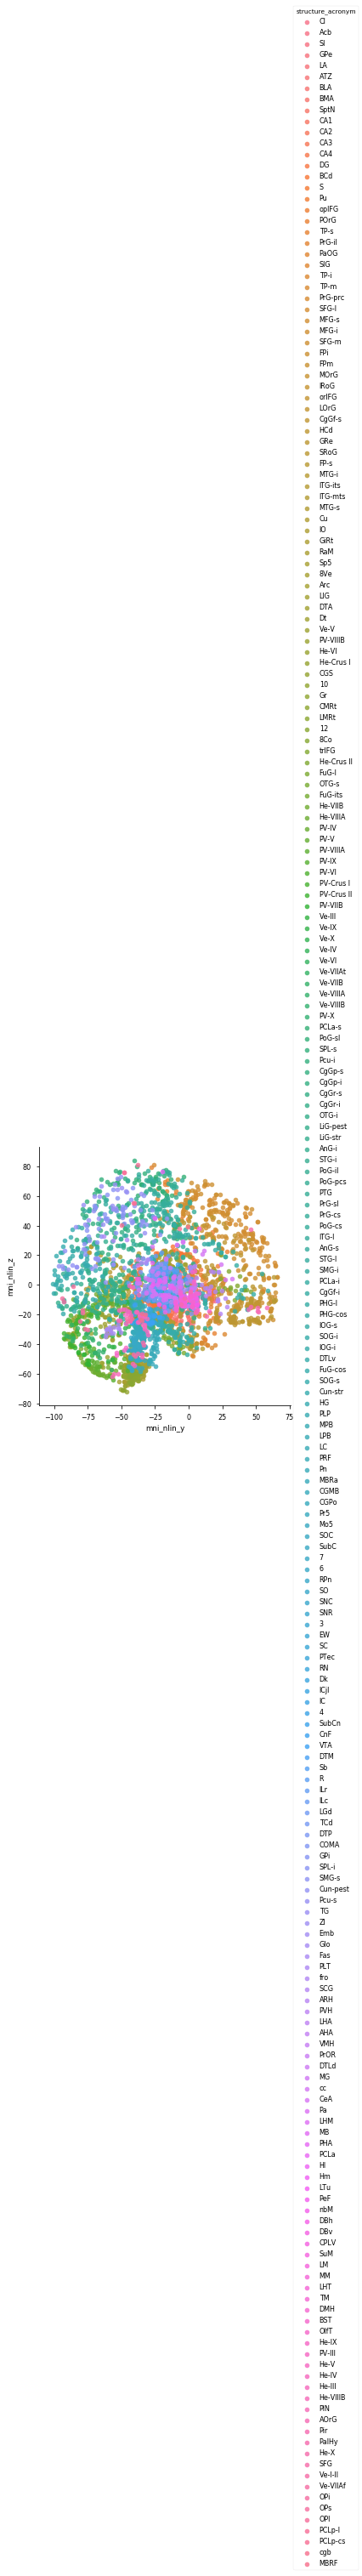

In [76]:
sns.lmplot('mni_nlin_y', 'mni_nlin_z', hue = 'structure_acronym', data=gdf, fit_reg=False)

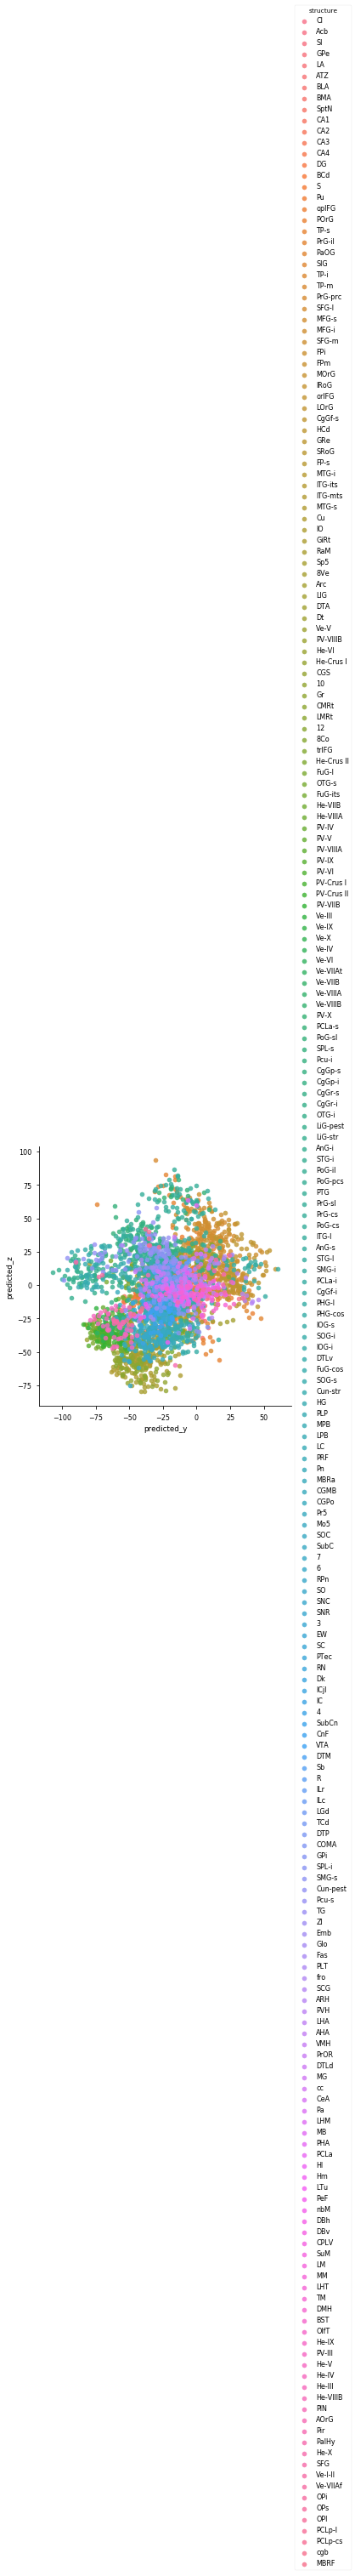

In [74]:
sns.lmplot('predicted_y', 'predicted_z', hue = 'structure', data=preds_df, fit_reg=False)

## Separately for brainstem/cerebellum/cortex

In [33]:
bigdf.shape

(3702, 58692)

In [35]:
train_test_split?

running PCA
explained variance with PCA: 0.753170957658
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


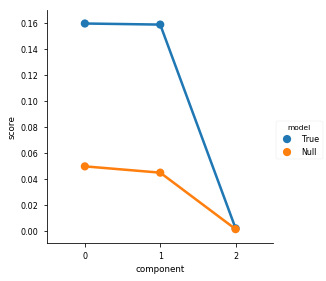

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.048  ***
applying to test data


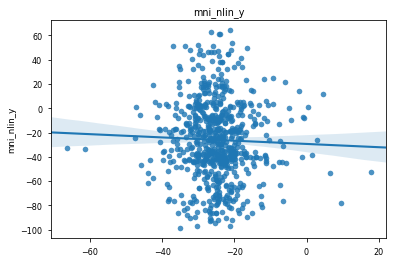

(-0.032934131348281201, 0.38874915740961791)
26.9481369163


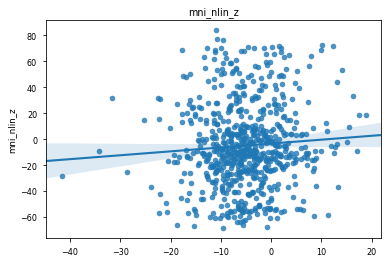

(0.067841037196471082, 0.075573250472683443)
25.5339587165


In [41]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf[gdf[gdf.slab_type=='CX'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
pls_mod.fit(tr,tr_y)
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.839794431874
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


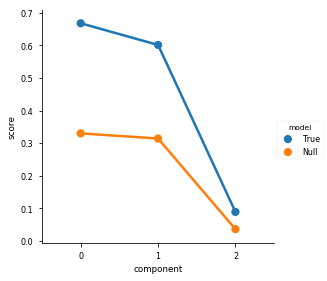

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


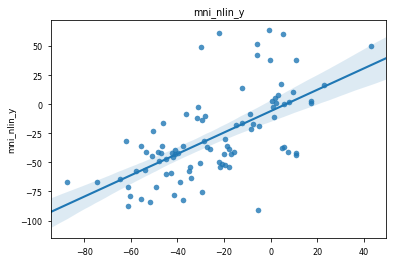

(0.62977954160046179, 1.7539972645040177e-11)
21.3889240094


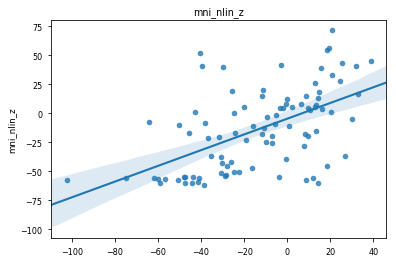

(0.55158399270751934, 1.2087356463909593e-08)
22.5800184788


In [42]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf[gdf[gdf.slab_type=='CB'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


running PCA
explained variance with PCA: 0.7588259226
transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


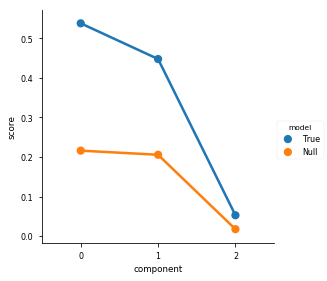

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


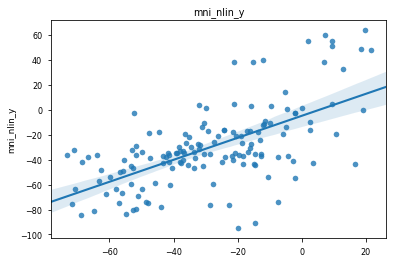

(0.62255268184596413, 3.8307047487734706e-17)
18.7566656993


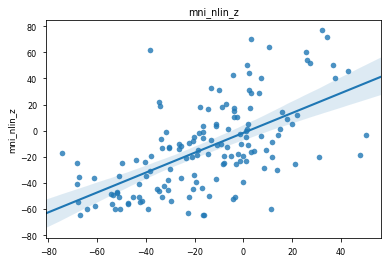

(0.60361067962148252, 5.8647935153696357e-16)
21.2772526264


In [43]:
print('running PCA')
pcamod = PCA(n_components=100, random_state=123).fit(bigdf[gdf[gdf.slab_type=='BS'].index,:])
print('explained variance with PCA:',sum(pcamod.explained_variance_ratio_))
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
# plot model fit
print('applying to test data')
pls_mod.fit(tr,tr_y)
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


#### now again with PCA from whole brain

In [185]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.7799918958717118

transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


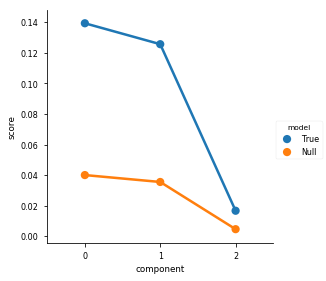

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


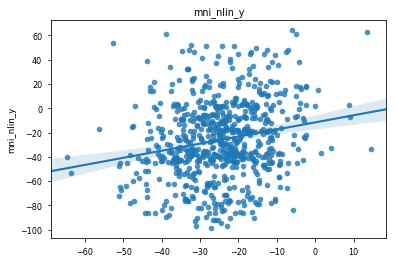

(0.19856949452676226, 1.5417215098159922e-07)
25.3992404148


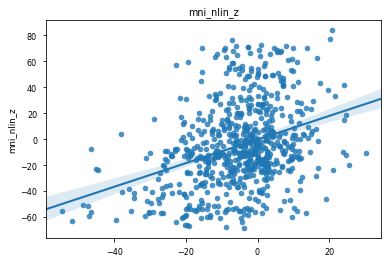

(0.34340830222573976, 1.8986225473245205e-20)
23.8765591865


In [187]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='CX'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


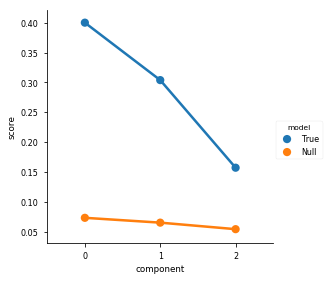

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


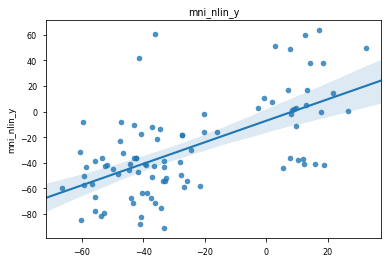

(0.61330956728370056, 8.0736956606204842e-11)
22.4791411378


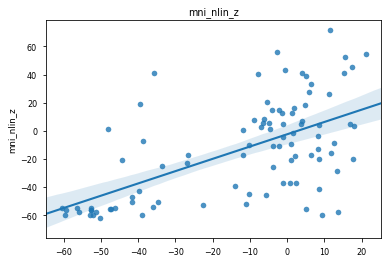

(0.60223053550620786, 2.1475813441239822e-10)
21.402379911


In [188]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='CB'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


transforming and splitting
fitting model to training data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400


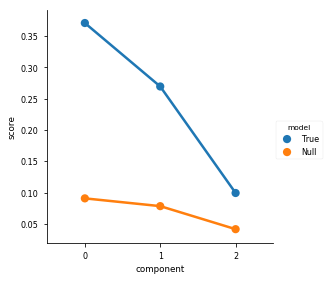

component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
applying to test data


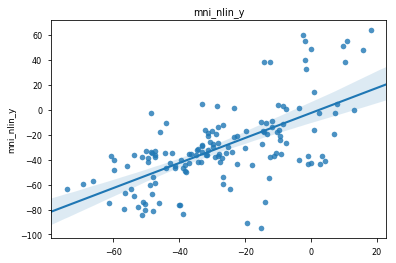

(0.63885411217318144, 3.1411296017323109e-18)
18.5227410581


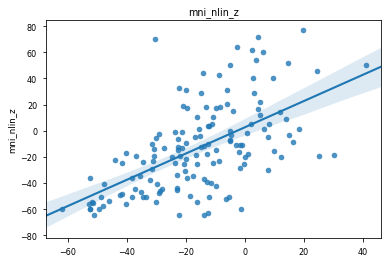

(0.58648616328070047, 5.9421491923054601e-15)
20.7559258542


In [189]:
print('transforming and splitting')
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf[gdf[gdf.slab_type=='BS'].index,:]))
tr,te = train_test_split(pca_tfm,random_state=123)
tr_y = gdf.loc[tr.index, ['mni_nlin_y','mni_nlin_z']]
te_y = gdf.loc[te.index, ['mni_nlin_y','mni_nlin_z']]
print('fitting model to training data')
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
# significant components?
print('evaluating output')
results, comp_sig = evaluate_components(pls_mod, tr, tr_y)
pls_mod.fit(tr,tr_y)
# plot model fit
print('applying to test data')
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
    plt.close()
    sns.regplot(te_pred[:,i], te_y[te_y.columns[i]])
    plt.title(te_y.columns[i])
    plt.show()
    print(stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]]))
    print(mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]]))


### dkt regions

In [77]:
dkt = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_DKT_label.csv',
                        index_col=0)
dkt = dkt[pandas.notnull(dkt.dkt_region)]

In [146]:
preds_df.head()

,predicted_y,predicted_z,mni_nlin_y,mni_nlin_z,slab_type
1568,6.827351,10.648121,51.434769,-11.080622,CX
1945,-6.641099,-3.214101,-1.331985,2.938835,CX
56,31.864854,22.509426,51.313781,42.465737,CX
1462,0.526959,-6.417761,-5.367327,-13.881810,CX
1771,-20.055102,-9.801642,-16.528890,-14.745722,CX


In [83]:
reg_results = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_dkt_regional_results.csv',
                            index_col=0)
reg_results.head()

,n,r2_y,r2_z,p_permuted_y,p_permuted_z,fdr_sig_y,fdr_Q_y,fdr_sig_z,fdr_Q_z
Putamen,71,0.193204,0.107371,0.002,0.010,True,0.004200,True,0.016154
Hypothalamus,3,0.846610,0.954112,0.002,0.002,True,0.004200,True,0.003818
Hippocampus,202,0.090164,0.225219,0.002,0.002,True,0.004200,True,0.003818
Pars opercularis,17,0.511083,0.460325,0.004,0.006,True,0.007636,True,0.010080
Superior Temporal,121,0.450381,0.741889,0.002,0.002,True,0.004200,True,0.003818


In [170]:
regions = dkt.dkt_region.unique()
reg_results = pandas.DataFrame(index=regions, columns = ['n','r2_y','r2_z', 'p_permuted_y', 'p_permuted_z'])
for reg in regions:
    rdf = dkt[dkt.dkt_region==reg]
    reg_results.loc[reg,'n'] = len(rdf)
    preds = pls_mod.predict(pca_tfm.loc[rdf.index])
    pred_y = preds[:,0]
    r2y = stats.pearsonr(pred_y, rdf.loc[:,'mni_nlin_y'].values)[0]**2
    reg_results.loc[reg,'r2_y'] = r2y
    pred_z = preds[:,1]
    r2z = stats.pearsonr(pred_z, rdf.loc[:,'mni_nlin_z'].values)[0]**2
    reg_results.loc[reg,'r2_z'] = r2z
    
    r2s_y = []
    r2s_z = []
    for i in range(500):
        newy = np.random.permutation(range(len(pred_y)))
        r2s_y.append(stats.pearsonr(newy, rdf.loc[:,'mni_nlin_y'].values)[0]**2)
        newz = np.random.permutation(range(len(pred_z)))
        r2s_z.append(stats.pearsonr(newz, rdf.loc[:,'mni_nlin_z'].values)[0]**2)
    py = (len(np.array(r2s_y)[r2s_y>r2y])+1) / len(r2s_y)
    pz = (len(np.array(r2s_z)[r2s_z>r2z])+1) / len(r2s_z)
    reg_results.loc[reg,'p_permuted_y'] = py
    reg_results.loc[reg,'p_permuted_z'] = pz
    print('finished',reg)

finished  Putamen
finished  Basal forebrain
finished  Hypothalamus
finished  Insula
finished  Globus Pallidus
finished  Amygdala
finished  entorinal
finished  Hypothalamus???
finished  Lingual gyrus
finished  Hippocampus
finished  Pars opercularis
finished  Superior Temporal
finished  Precentral
finished  Inferior temporal
finished  Middle temporal
finished  Caudal middle frontal
finished  Superior frontal
finished  Lateral orbitofronal
finished  Medial orbitofrontal
finished  Caudal anterior cingulate
finished  Rostral middle frontal
finished  Rostral anterior cingulate
finished  Caudate
finished  L Cerebellum
finished  R Cerebellum
finished  Pars triangularis
finished  Posterior cingulate
finished  fusiform
finished  Lateral Occipital
finished  Paracentral 
finished  Precuneus
finished  Isthmus cingulate
finished  Inferior parietal
finished  Supramarginal
finished  Superior parietal
finished  Thalamus
finished  Transverse temporal
finished  Parahippocampal
finished  Postcentral
finis

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [176]:
reg_results.loc[:,'fdr_sig_y'] = multipletests(reg_results.p_permuted_y,method='fdr_bh')[0]
reg_results.loc[:,'fdr_Q_y'] = multipletests(reg_results.p_permuted_y,method='fdr_bh')[1]

reg_results.loc[:,'fdr_sig_z'] = multipletests(reg_results.p_permuted_z,method='fdr_bh')[0]
reg_results.loc[:,'fdr_Q_z'] = multipletests(reg_results.p_permuted_z,method='fdr_bh')[1]

In [ ]:
reg_results.loc[reg_results[(reg_results.fdr_sig_y==False) & (reg_results.fdr_sig_z==False)
                           ].index,'type'] = 1
reg_results.loc[reg_results[(reg_results.fdr_sig_y==False) & (reg_results.fdr_sig_z==True)
                           ].index,'type'] = 2
reg_results.loc[reg_results[(reg_results.fdr_sig_y==True) & (reg_results.fdr_sig_z==False)
                           ].index,'type'] = 3
reg_results.loc[reg_results[(reg_results.fdr_sig_y==True) & (reg_results.fdr_sig_z==True)
                           ].index,'type'] = 4

In [ ]:
for reg in reg_results.index:
    reg_results.loc[reg,'label'] = dkt[dkt.dkt_region==reg]['dkt_label'].values[0]
reg_results.loc[:,'label'] = [x-39 if x < 39 else x for x in reg_results.label.values]

In [195]:
reg_results.sort_values(['fdr_sig_y','fdr_sig_z'],ascending=False
                       ).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_dkt_regional_results.csv')

In [ ]:
dkt_img = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii')
dat = dkt_img.get_data()
sigtype = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    sigtype[dat==row['label']] = row['type']
ni.Nifti1Image(sigtype, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_sigtype')

In [ ]:
yr2_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    yr2_img[dat==row['label']] = row['r2_y']
ni.Nifti1Image(yr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_r2_y')

zr2_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    zr2_img[dat==row['label']] = row['r2_z']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_r2_z')

zp_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    zp_img[dat==row['label']] = row['fdr_Q_z']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_fdrq_z')

yp_img = np.zeros_like(dat)
for i,row in reg_results.iterrows():
    yp_img[dat==row['label']] = row['fdr_Q_y']
ni.Nifti1Image(zr2_img, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_fdrq_y')

## Explaining y rotations!

In [131]:
print(pls_mod.y_rotations_, )
print(pls_mod.y_loadings_)
print(pls_mod.y_weights_)

[[ -6.28269075e-01  -1.09306756e+00   2.43345410e-16]
 [ -7.70544718e-01   8.90198611e-01   1.90667820e-15]]
[[ -6.35156711e-01  -5.49783658e-01   6.46315909e-16]
 [ -7.79903706e-01   4.48269987e-01   1.60344693e-15]]
[[ -6.35156711e-01  -5.49783658e-01   6.46315909e-16]
 [ -7.79903706e-01   4.48269987e-01   1.60344693e-15]]


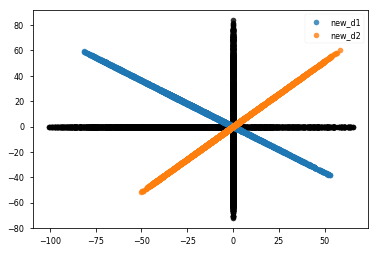

ORIGINAL AXES


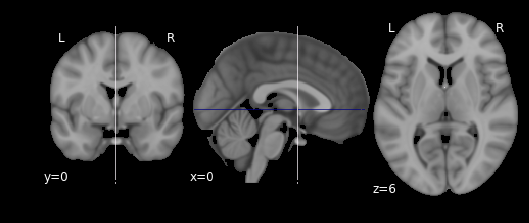

ROTATED AXES


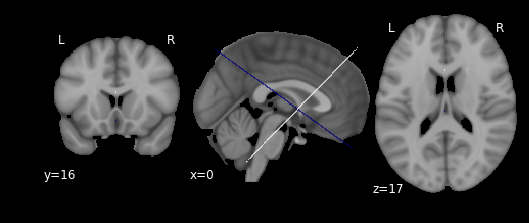

In [135]:
rotate_2d(pls_mod, gdf[['mni_nlin_y','mni_nlin_z']], component = 0, return_rotations = False, 
          mni_pth='/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')

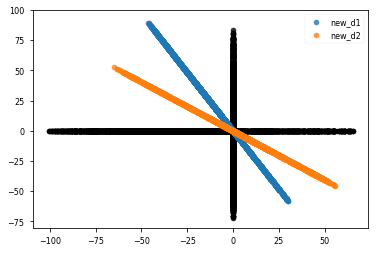

ORIGINAL AXES


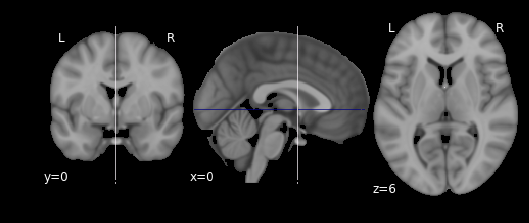

ROTATED AXES


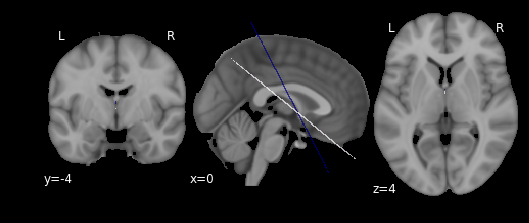

In [136]:
rotate_2d(pls_mod, gdf[['mni_nlin_y','mni_nlin_z']], component = 1, return_rotations = False, 
          mni_pth='/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')

## Exploring X!

TO DO
----------

* Plot gene expression image for each component
* Work on getting more out of the x features
    * Only keep certain Xs based on bootstrap ratio
    * Do GSEA stuff
* Do the previous with bootstrap ratio and loading
* Repeat with the second component



In [500]:
bsrx,_, allx_bs, jnk = bootstrap_features(PLSRegression(n_components=3), pls_mod, pca_tfm, 
                                     gdf[['mni_nlin_y','mni_nlin_z']], n_iterations=1000)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


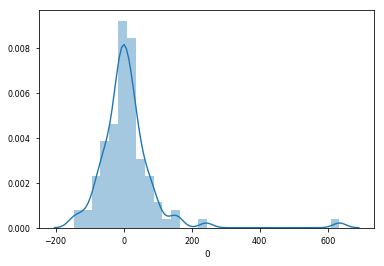

In [440]:
sns.distplot(bsrx['bsr'].loc[0])

#### Component 1

In [502]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       pandas.Series(list(range(100))*500)],
                      axis=1)
plotr.columns = ['Loading','Component']

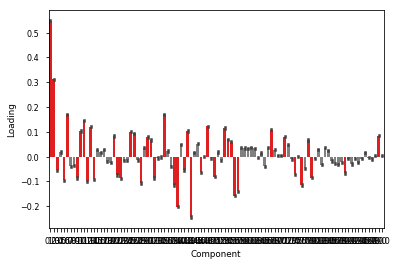

In [503]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

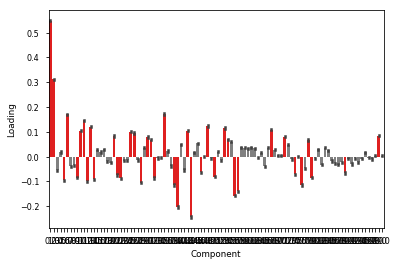

In [509]:
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

In [514]:
pca_tfm.shape

(3702, 100)

In [516]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]

In [522]:
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), probes[['gene_symbol','gene_name']]], axis=1)

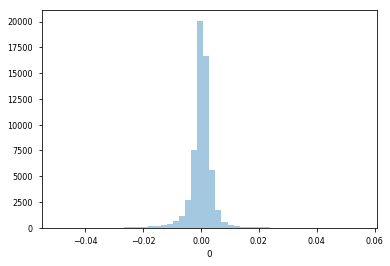

In [528]:
sns.distplot(newc1[0],kde=False)

In [524]:
newc1.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
26396,0.055503,PAX2,paired box 2
3404,0.051974,MET,met proto-oncogene (hepatocyte growth factor r...
612,0.049162,DAO,D-amino-acid oxidase
2313,0.046275,HOXB5,homeobox B5
3405,0.045402,MET,met proto-oncogene (hepatocyte growth factor r...
2306,0.045128,HOXB2,homeobox B2
53500,0.043142,A_24_P815062,AGILENT probe A_24_P815062 (non-RefSeq)
2307,0.042331,HOXB3,homeobox B3
2290,0.041858,HOXA4,homeobox A4
3403,0.039035,MET,met proto-oncogene (hepatocyte growth factor r...


In [ ]:
newc1.sort_values(0,ascending=False).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_c1_x_tfm.csv')

In [542]:
c1_xp = get_gene_vector(pandas.DataFrame(bigdf.T), newc1[0])

In [552]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c1'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
gcx_img = make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

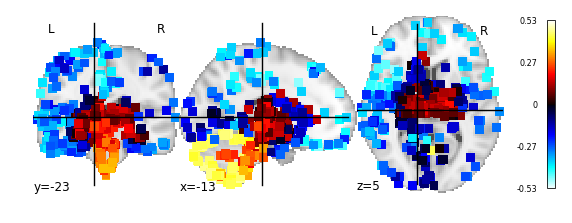

In [553]:
plotting.plot_stat_map(gcx_img)

#### component 2

In [529]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       pandas.Series(list(range(100))*500)],
                      axis=1)
plotr.columns = ['Loading','Component']

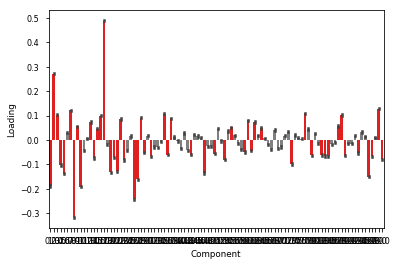

In [531]:
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

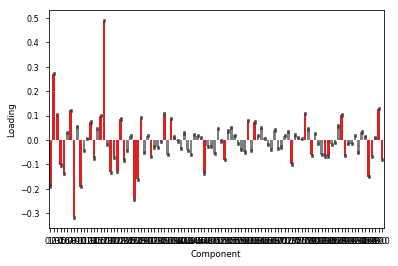

In [532]:
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)

In [533]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), probes[['gene_symbol','gene_name']]], axis=1)

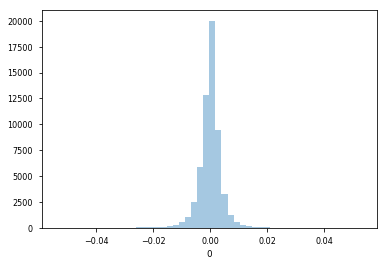

In [534]:
sns.distplot(newc2[0],kde=False)

In [535]:
newc2.sort_values(0,ascending=False)

,0,gene_symbol,gene_name
6582,0.053194,TTR,transthyretin
13405,0.035578,SOST,sclerostin
26331,0.033650,SCN1B,"sodium channel, voltage-gated, type I, beta su..."
16253,0.031912,DMRT3,doublesex and mab-3 related transcription fact...
5009,0.031423,PVALB,parvalbumin
5008,0.031311,PVALB,parvalbumin
6581,0.031234,TTR,transthyretin
31892,0.031082,CADPS2,Ca++-dependent secretion activator 2
26330,0.030806,SCN1B,"sodium channel, voltage-gated, type I, beta su..."
53627,0.028855,A_23_P417646,AGILENT probe A_23_P417646 (non-RefSeq)


In [536]:
newc2.sort_values(0,ascending=False).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_c2_x_tfm.csv')

In [554]:
c2_xp = get_gene_vector(pandas.DataFrame(bigdf.T), newc2[0])

In [555]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'NEUR608_IMG_c2'
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
gcx_img = make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

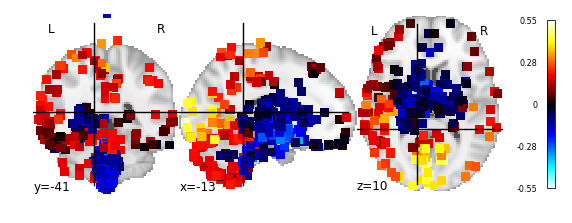

In [556]:
plotting.plot_stat_map(gcx_img)

In [513]:
#list(zip(pls_mod.x_loadings_[:,0],bsrx['bsr'].loc[0],bsrx['p'].loc[0]))

In [191]:
c1 = np.dot(pcamod.components_.T, bsrx.loc[0])
c1 = pandas.concat([pandas.Series(c1), probes[['gene_symbol','gene_name']]], axis=1)

In [194]:
c1.sort_values(0,ascending=False).to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_c1_x_tfm.csv')

OTHER TO DO
============
* Plot DKT images 
* Update Evaluation script to pass results [DONE]
* Plot predicted vs actual brain [DONE]
* Do results on Brainstem, Cerebellum and Cortex alone [DONE]
* Update bootstrap script to return mean, se, and significance [DONE]
* Explore adding x (3D)? [NOT DOING]
* Run analyses separately for every ROI and cluster [DONE}
* Run for random spheres and cluster [PROBABLY NOT DOING]

## PRINCIPAL AXES OF EVERY ROI

In [192]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
pa_dkt = pandas.DataFrame(index = reg_results[reg_results.n>10].index,
                         columns = [
                                    'c1_r2','c1_p',
                                    'c2_r2','c2_p',
                                    'c3_r2','c3_p',
                                    'model_fit_cv', 
                                    'y_rotation1','z_rotation1', 
                                    'y_rotation2','z_rotation2', 
                                    'y_rotation3','z_rotation3', 
                                    'notes'])
pa_dkt.loc[:,'n'] = reg_results[reg_results.n>10]['n'].values
for reg in pa_dkt.index:
    print('transforming and splitting')
    dpca_tfm = pandas.DataFrame(pcamod.transform(bigdf[dkt[dkt.dkt_region==reg].index,:]))
    dy = dkt[dkt.dkt_region==reg][['mni_nlin_y','mni_nlin_z']]
    print('fitting model to data')
    pls_mod = PLSRegression(n_components=3)
    pls_mod.fit(dpca_tfm,dy)
    # significant components?
    print('evaluating output')
    _, dcomp_sig = evaluate_components(pls_mod, dpca_tfm, dy, plot=False)
    print('storing results')
    pls_mod.fit(dpca_tfm,dy)
    if all(dcomp_sig.sig==0):
        pa_dkt.loc[reg,'notes'] = 'no significant components'
        continue
    else: 
        pa_dkt.loc[reg,'c1_r2'] = dcomp_sig.loc[0,'r']
        pa_dkt.loc[reg,'c1_p'] = dcomp_sig.loc[0,'p']
        pa_dkt.loc[reg,'y_rotation1'] = pls_mod.y_rotations_[0,0]
        pa_dkt.loc[reg,'z_rotation1'] = pls_mod.y_rotations_[1,0]
        pa_dkt.loc[reg,'c2_r2'] = dcomp_sig.loc[1,'r']
        pa_dkt.loc[reg,'c2_p'] = dcomp_sig.loc[1,'p']
        pa_dkt.loc[reg,'y_rotation2'] = pls_mod.y_rotations_[0,1]
        pa_dkt.loc[reg,'z_rotation2'] = pls_mod.y_rotations_[1,1]
        pa_dkt.loc[reg,'c3_r2'] = dcomp_sig.loc[2,'r']
        pa_dkt.loc[reg,'c3_p'] = dcomp_sig.loc[2,'p']
        pa_dkt.loc[reg,'y_rotation3'] = pls_mod.y_rotations_[0,2]
        pa_dkt.loc[reg,'z_rotation3'] = pls_mod.y_rotations_[1,2]
    # plot model fit
    print('finding cross-validated model filt')
    pred = cross_val_predict(PLSRegression(n_components=3), dpca_tfm, dy, cv=10)
    cv = r2_score(y_true=dy, y_pred=pred)
    pa_dkt.loc[reg,'model_fit_cv'] = cv
    
    


transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
storing results
finding cross-validated model filt
transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.002  ***
component 1: p = 0.002  ***
component 2: p = 0.002  ***
storing results
finding cross-validated model filt
transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.07
component 1: p = 0.82
component 2: p = 0.004  ***
storing results
finding cross-validated model filt
transforming and splitting
fitting model to data
evaluating output


finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.114
component 1: p = 0.108
component 2: p = 0.164
storing results
transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.244
component 1: p = 0.018  ***
component 2: p = 0.106
storing results
finding cross-validated model filt
transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.466
component 1: p = 0.276
component 2: p = 0.642
storing results
transforming and splitting
fitting model to data
evaluating output
finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
component 0: p = 0.13
component 1: p = 0.49
component 2: p = 0.138
storin

In [193]:
pa_dkt

,c1_r2,c1_p,c2_r2,c2_p,c3_r2,c3_p,model_fit_cv,y_rotation1,z_rotation1,y_rotation2,z_rotation2,y_rotation3,z_rotation3,notes,n
Putamen,0.681477,0.002,0.637874,0.002,0.442429,0.002,0.420836,-0.247154,-2.90333,-3.13472,-1.42745,1.00678,-0.656458,NaN,71
Hippocampus,0.435684,0.002,0.292217,0.002,0.184525,0.002,0.293984,-1.03308,0.796186,7.00772,6.23529,9.00941,10.5537,NaN,202
Pars opercularis,0.772616,0.07,0.515313,0.82,0.86212,0.004,0.228623,-0.0824226,-3.53379,-0.882668,-0.615095,4.85008,-4.66657,NaN,17
Superior Temporal,0.697993,0.002,0.382198,0.002,0.269582,0.002,0.607957,-0.365764,1.94494,1.42468,2.83315,7.88927,7.50968,NaN,121
Precentral,0.675421,0.002,0.313969,0.05,0.262943,0.05,0.443295,-8.80705,-6.06456,-14.8427,-16.2476,4.65228,5.86336,NaN,65
Inferior temporal,0.654867,0.002,0.3744,0.002,0.153238,0.004,0.465375,-4.71354,-2.69722,-2.83399,-1.76457,-21.3704,-21.5775,NaN,133
Middle temporal,0.624686,0.002,0.481945,0.002,0.349616,0.002,0.57638,-4.54583,-2.59219,5.33111,4.32815,-15.2705,-15.6279,NaN,108
Superior frontal,0.739737,0.002,0.404221,0.002,0.34999,0.002,0.648226,-5.67019,-3.37571,12.3021,11.2869,-24.3676,-25.4922,NaN,102
Medial orbitofrontal,0.610926,0.004,0.52091,0.02,0.460238,0.07,0.20503,-3.26012,1.20615,-0.448521,-2.93533,-1.86321,0.953585,NaN,45
Rostral middle frontal,0.624131,0.002,0.403762,0.02,0.391353,0.048,-0.012873,1.86579,-0.753184,1.28758,-0.131513,3.44575,3.59483,NaN,57


In [194]:
jnk = pa_dkt[pandas.notnull(pa_dkt.y_rotation1)][['y_rotation1','z_rotation1']]
jnk.loc[:,'y_rotation1'] = jnk.y_rotation1.astype('float').values
jnk.loc[:,'z_rotation1'] = jnk.z_rotation1.astype('float').values

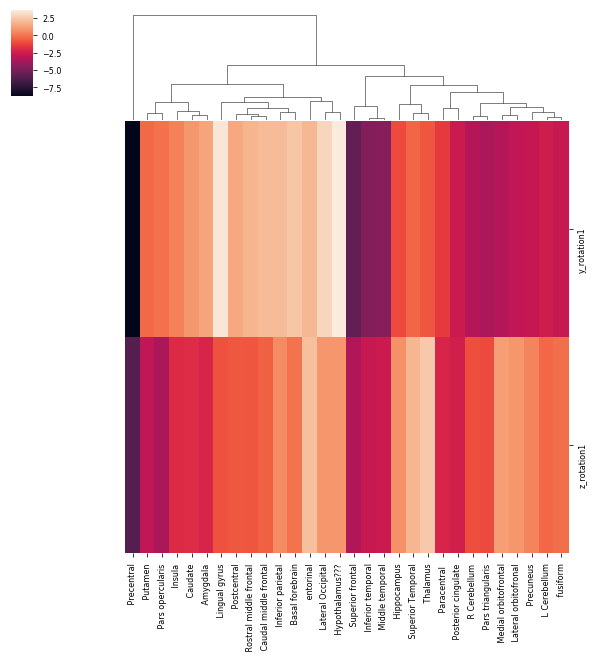

In [195]:
sns.clustermap(jnk.T, row_cluster=False)

In [201]:
ks = range(2,8)
basc_results = pandas.DataFrame(index = ks, columns = ['k','silhouette', 'CH_index',
                                                        'mean_size','min_size','max_size'])
basc_results.loc[:,'k'] = ks
for k in ks:
    print('>>>>>>> k = %s <<<<<<<'%k)
    output = vb.poormans_basc(jnk, k, 100, 100, True, None, True, 10, plotit=False)
    # scores
    basc_results.loc[k,'CH_index'] = calinski_harabaz_score(output['stability'],
                                                              output['labels'])
    basc_results.loc[k,'silhouette'] = silhouette_score(output['stability'],
                                                      output['labels'])
    # sizes
    sizes = [len(output['labels'][output['labels']==x]) for x in np.unique(output['labels'])]
    basc_results.loc[k,'mean_size'] = np.mean(sizes)
    basc_results.loc[k,'min_size'] = np.min(sizes)
    basc_results.loc[k,'max_size'] = np.max(sizes)

>>>>>>> k = 2 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 3 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 4 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 5 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 6 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0
>>>>>>> k = 7 <<<<<<<
running cluster analyses
working on iteration 0
creating stability matrix
working on iteration 0


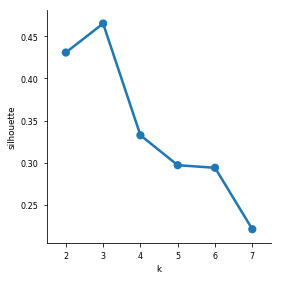

In [202]:
sns.factorplot(x='k', y='silhouette', data=basc_results)

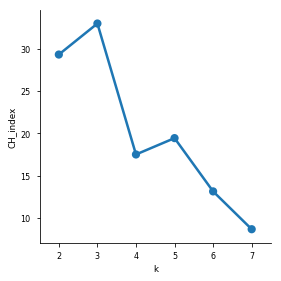

In [203]:
sns.factorplot(x='k', y='CH_index', data=basc_results)

running cluster analyses
working on iteration 0
working on iteration 100
working on iteration 200
working on iteration 300
working on iteration 400
working on iteration 500
working on iteration 600
working on iteration 700
working on iteration 800
working on iteration 900
creating stability matrix
working on iteration 0
working on iteration 100
working on iteration 200
working on iteration 300
working on iteration 400
working on iteration 500
working on iteration 600
working on iteration 700
working on iteration 800
working on iteration 900


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


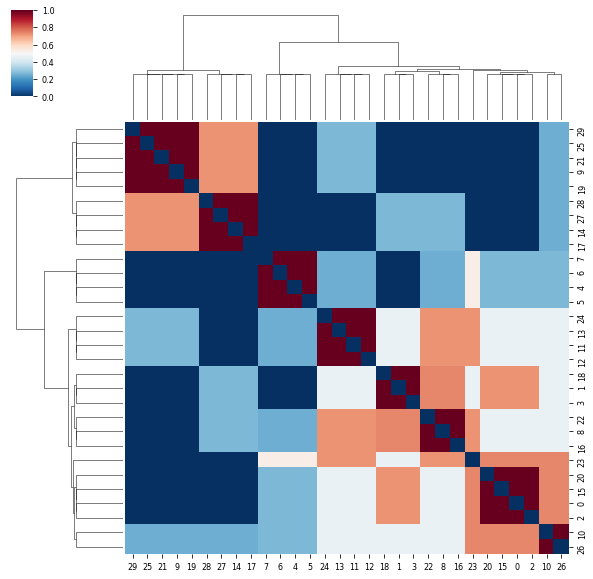

In [204]:
res = vb.poormans_basc(jnk,3,1000,100,bootstrap = True,
                  inner_cluster_object = None,
                  connect = True, neighbors = 10,
                  plotit = True)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


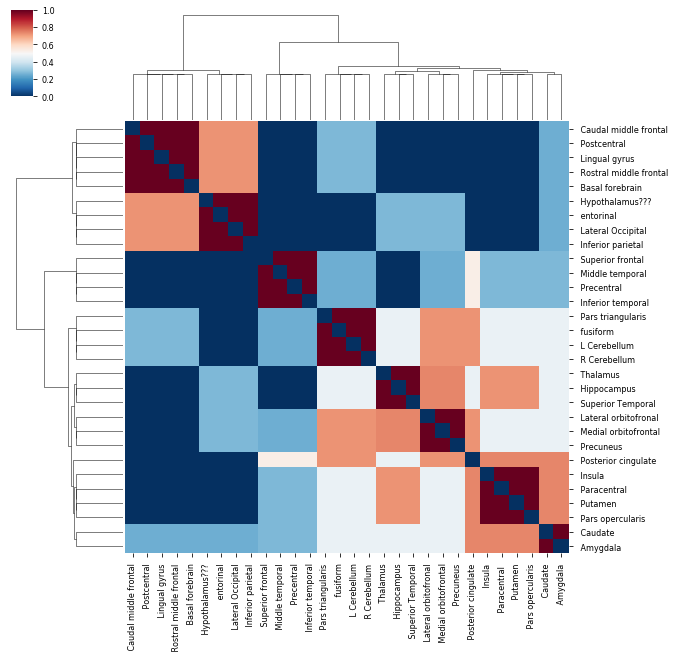

In [205]:
sns.clustermap(pandas.DataFrame(res['stability'], index = jnk.index, columns = jnk.index), cmap='RdBu_r')

In [206]:
pa_dkt.loc[pa_dkt[pandas.notnull(pa_dkt.y_rotation1)].index,'cluster'] = res['labels']

In [207]:
pa_dkt.columns

Index(['c1_r2', 'c1_p', 'c2_r2', 'c2_p', 'c3_r2', 'c3_p', 'model_fit_cv',
       'y_rotation1', 'z_rotation1', 'y_rotation2', 'z_rotation2',
       'y_rotation3', 'z_rotation3', 'notes', 'n', 'cluster'],
      dtype='object')

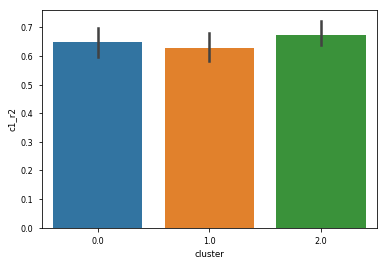

In [210]:
sns.barplot(x='cluster',y='c1_r2', data=pa_dkt)

In [211]:
for reg in pa_dkt.index:
    pa_dkt.loc[reg,'label'] = dkt[dkt.dkt_region==reg]['dkt_label'].values[0]
pa_dkt.loc[:,'label'] = [x-39 if x > 39 else x for x in pa_dkt.label.values]

In [212]:
dkt_img = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii')
dat = dkt_img.get_data()
clusty = np.zeros_like(dat)
for i,row in pa_dkt.iterrows():
    clusty[dat==row['label']] = row['cluster']+1


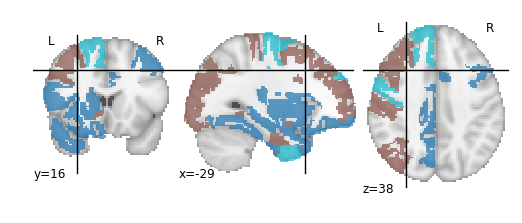

In [215]:
plotting.plot_roi(ni.Nifti1Image(clusty, dkt_img.affine), cmap='tab10')

In [216]:
ni.Nifti1Image(clusty, dkt_img.affine).to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608_IMG_axis_cluster')

FOR CLUSTER 1.0


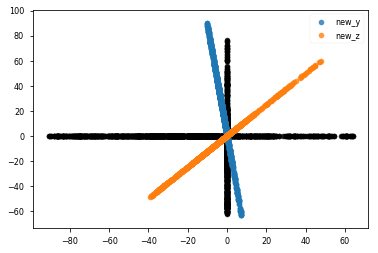

ORIGINAL AXES


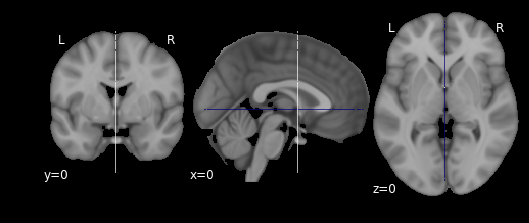

ROTATED AXES


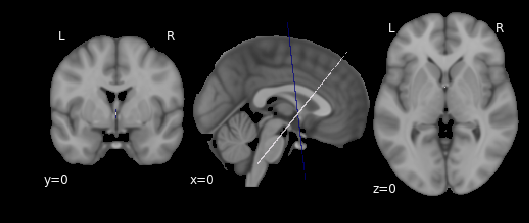

FOR CLUSTER 3.0


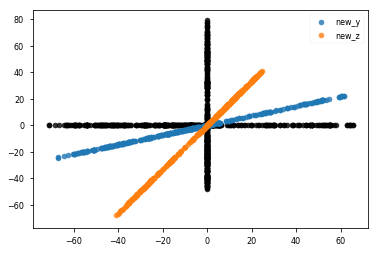

ORIGINAL AXES


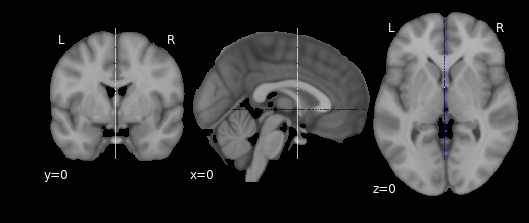

ROTATED AXES


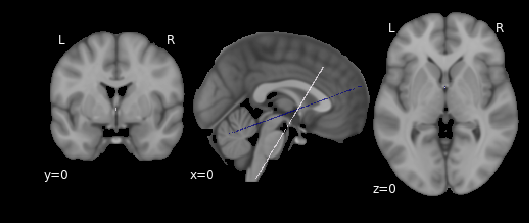

FOR CLUSTER 2.0


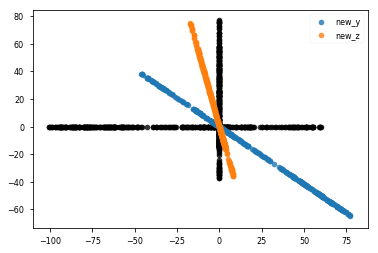

ORIGINAL AXES


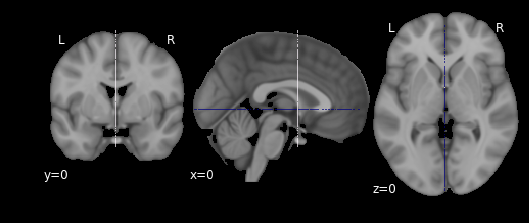

ROTATED AXES


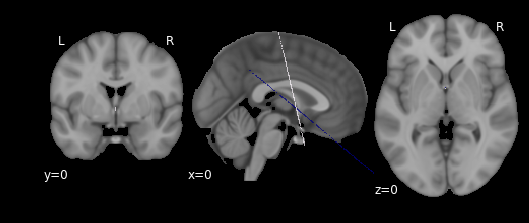

In [237]:
for k in pa_dkt.cluster.unique():
    if pandas.notnull(k):
        print('FOR CLUSTER',k+1)
        yrot = pa_dkt[pa_dkt.cluster==k]['y_rotation1'].mean()
        zrot = pa_dkt[pa_dkt.cluster==k]['z_rotation1'].mean()
        bigy = dkt[dkt.dkt_region.isin(pa_dkt[pa_dkt.cluster==k].index)][['mni_nlin_y','mni_nlin_z']]
        rotate_2d(None, bigy, component = 0, return_rotations = False, provide_rotations=[yrot,zrot],
                 mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
        

In [225]:
yrot

2.4465741757360728

In [130]:
pa_dkt.columns[8:-2]

Index(['y_rotation1', 'z_rotation1', 'y_rotation2', 'z_rotation2',
       'y_rotation3', 'z_rotation3'],
      dtype='object')

In [132]:
jnk = pa_dkt[pandas.notnull(pa_dkt.y_rotation1)][pa_dkt.columns[8:-2]]
for col in jnk:
    jnk.loc[:,col] = jnk[col].astype(float).values

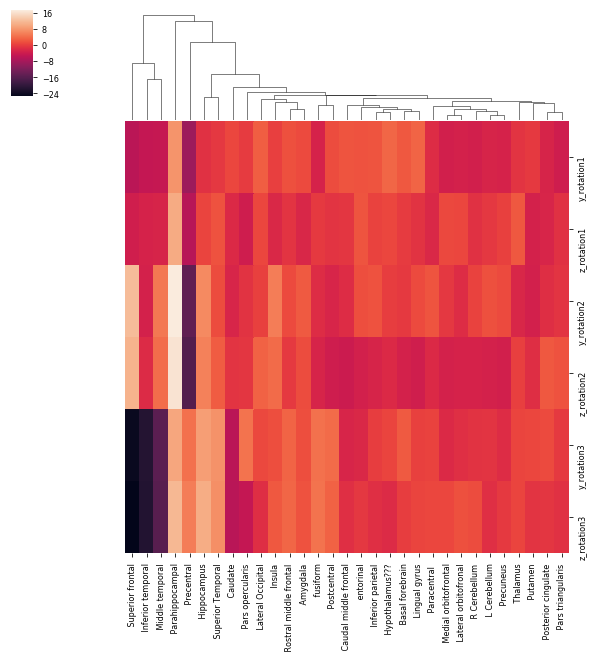

In [133]:
sns.clustermap(jnk.T, row_cluster=False)

## ADDING X

In [11]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)

NameError: name 'gdf' is not defined

In [12]:
tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

NameError: name 'pca_tfm' is not defined

In [13]:
plotr = pandas.concat([pandas.Series(cca_mod.predict(te)[:,0], index = te_y.index), 
                       pandas.Series(cca_mod.predict(te)[:,1], index = te_y.index),
                       pandas.Series(cca_mod.predict(te)[:,2], index = te_y.index),
                       pandas.Series(te_y.loc[:,te_y.columns[0]]),
                       pandas.Series(te_y.loc[:,te_y.columns[1]]),
                       pandas.Series(te_y.loc[:,te_y.columns[2]]),
                       gdf.loc[te_y.index,'slab_type']], 
                      axis=1)
plotr.columns = ['predicted_y', 'predicted_z', 'predicted x',
                 'observed_y', 'observed_z', 'observed_x', 'slab_type']

SyntaxError: invalid syntax (<ipython-input-13-186986e08cb9>, line 4)

In [ ]:
for i in range(3):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+3], data = plotr)
    plt.show()
    print(stats.pearsonr(cca_mod.predict(te)[:,i],te_y.loc[:,te_y.columns[i]]))

In [ ]:
for i in range(3):
    plt.close()
    sns.lmplot(plotr.columns[i], plotr.columns[i+3], col = 'slab_type', data = plotr)
    plt.show()

## less components

In [ ]:
cca_mod = PLSRegression(n_components=1)
cca_mod.fit(tr,tr_y)

Notes
================

* PCA first then PLS works plenty well and also very fast -- will support 10-fold CV (0.83, 0.89, 0.74)
* Keeping the same number of components as Ys leaves Ys orthogonal
* Y and Z are predicted well (r < 0.8), x not nearly as well (r ~ 0.5)
* Combination X,Y,Z, with 1 component seems to favor Z but cost all three (0.53, 0.80, 0.40)
* Combination X,Y,Z with 2 components maintains Y (0.8) and combines Z and X (0.82, 0.60).
* Forcing Z and Y together (no X) hurts both (0.63, 0.78)
* It seems 

In [14]:
np.random.permutation?

In [282]:
def evaluate_components(clf, x, y, n_iterations=500, check = 100,
                       evaluate = True, plot = True, thr = 0.95):
    
    if type(x) != type(pandas.DataFrame()):
        x = pandas.DataFrame(x)
    
    # fit model
    clf.fit(x,y)
    n_comps = clf.n_components
    
    # prepare output
    results = pandas.DataFrame(index = range(n_comps * (n_iterations+1)),
                              columns = ['score', 'component', 'model'])
    results.loc[:,'component'] = list(range(n_comps))*(n_iterations+1)
    results.loc[range(n_comps),'model'] = ['True']*n_comps
    results.loc[range(n_comps,n_comps*(n_iterations+1)), 'model'
               ] = ['Null']*(n_comps*n_iterations)
    
    true_scores = [stats.pearsonr(clf.x_scores_[:,x], clf.y_scores_[:,x]
                                 )[0]**2 for x in range(n_comps)]
    results.loc[results[results.model=='True'].index,'score'] = true_scores
    
    k = clf.n_components
    # permute and refit model
    for i in range(n_iterations):
        new_ind = np.random.permutation(x.index)
        new_x = x.loc[new_ind]
        newmod = clf.fit(new_x,y)
        new_scores = [stats.pearsonr(newmod.x_scores_[:,x], newmod.y_scores_[:,x]
                                 )[0]**2 for x in range(n_comps)]
        results.loc[range(k, k+n_comps), 'score'] = new_scores
        if check:
            if i % check == 0:
                print('finished iteration',i)
        
        k += n_comps
        
    if evaluate:
        if plot:
            cr = display_results(results, thr)
        else:
            cr = display_results(results, thr, False)
        
    return results, cr

def display_results(results, thr = 0.95, plot=True):
    
    if plot:
        # plot components
        sns.set_context('paper')
        plt.close()
        sns.factorplot(x='component', y = 'score', hue='model', data=results)
        plt.show()
    
    # get p-values
    comp_results = pandas.DataFrame(index=results.component.unique(),
                                   columns = ['r','p','sig'])
    for i in results.component.unique():
        nullz = results[(results.component==i) & (results.model=='Null')
                       ]['score'].sort_values().values
        real = results[(results.component==i) & (results.model=='True')]['score'].values[0]
        comp_results.loc[i,'r'] = real
        p = (len(nullz[nullz>real])+1) / len(nullz)
        if p < (1 - thr):
            comp_results.loc[i,['p','sig']] = [p, 1]
            print('component %s: p = %s  ***'%(i,p))
        else:
            comp_results.loc[i,['p','sig']] = [p, 0]
            print('component %s: p = %s'%(i,p))
        
    
    return comp_results

In [235]:
def rotate_2d(clf, y, component = 0, return_rotations = False, mni_pth=None, vs=1, 
              provide_rotations = None):
    
    if type(y) == type(pandas.DataFrame()):
        y = y.values
    d1 = y[:,0]
    d2 = y[:,1]
    
    if type(provide_rotations) != type(None):
        if type(provide_rotations) == list:
            d1_wt = provide_rotations[0]
            d2_wt = provide_rotations[1]
        else:
            d1_wt = clf.y_rotations_[0, component]
            d2_wt = clf.y_rotations_[1, component]
    else:
        d1_wt = provide_rotations[0, component]
        d2_wt = provide_rotations[1, component]
    null = np.zeros(len(d1))
    
    d1_rot_x = d1 * np.cos(d1_wt) - null * np.sin(d1_wt)
    d1_rot_y = d1 * np.sin(d1_wt) + null * np.cos(d1_wt)
    d2_rot_x = null * np.cos(d2_wt) - d2 * np.sin(d2_wt)
    d2_rot_y = null * np.sin(d2_wt) + d2 * np.cos(d2_wt)
    
    plt.close()
    sns.regplot(x = d1, y = null, fit_reg=False, color = 'k')
    sns.regplot(x = null, y = d2, fit_reg=False, color = 'k')
    sns.regplot(x = d1_rot_x, y = d1_rot_y, fit_reg=False, label = 'new_y')
    sns.regplot(x = d2_rot_x, y = d2_rot_y, fit_reg=False, label = 'new_z')
    plt.legend()
    plt.show()
    
    if mni_pth:
        print('ORIGINAL AXES')
        mni_display(mni_pth, d1, null, null, d2, vs)
        print('ROTATED AXES')
        mni_display(mni_pth, d1_rot_x, d1_rot_y, d2_rot_x, d2_rot_y, vs)
    
    if return_rotations:
        return d1_rot_x, d1_rot_y, d2_rot_x, d2_rot_y
        
def mni_display(mni_pth, x1, x2, y1, y2, vs=1):
    
    mni = ni.load(mni_pth)
    axes = np.zeros_like(mni.get_data())
    
    iy = [convert_coords((0, x1[x], x2[x]), to_what='xyz', vs=vs) for x in range(len(x2))]
    iz = [convert_coords((0,  y1[x], y2[x]), to_what='xyz', vs=vs) for x in range(len(y2))]
    
    for coord in iy:
        coord = tuple([int(round(x)) for x in coord]) 
        axes[coord] = 1
    for coord in iz:
        coord = tuple([int(round(x)) for x in coord]) 
        axes[coord] = 2
    
    axes_img_null = ni.Nifti1Image(axes, affine=mni.affine)
    plt.close()
    plotting.plot_roi(axes_img_null, mni,  draw_cross=False, cut_coords=[0,0,0])
    plt.show()

In [232]:
plotting.plot_roi(cut_coords=[0,0,0])

In [230]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]

    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs

    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]

    else:
        raise IOError('please set to_what to either mni or xyz')

    return x,y,z

In [ ]:
convert_coords([0,0,0], to_what='xyz')

In [2]:
#CHANGE

In [ ]:
mni = ni.load(MNI152_FILE_PATH)


## Features

In [499]:
def bootstrap_features(clf, fit_model, X, y, n_iterations=500, check = 100, on ='x'):
    
    if type(X) != type(pandas.DataFrame()):
        X = pandas.DataFrame(X)
    if type(y) != type(pandas.DataFrame()):
        y = pandas.DataFrame(y)

    # fit model
    orig = fit_model

    # prepare output
    n_feats_x = X.shape[-1]
    n_feats_y = y.shape[-1]
    all_results_x = {}
    all_results_y = {}

    for i in range(orig.n_components):
        results = pandas.DataFrame(index = range(n_iterations), columns = range(n_feats_x))
        all_results_x.update({i: results})
        results = pandas.DataFrame(index = range(n_iterations), columns = range(n_feats_y))
        all_results_y.update({i: results})
    bs_ratio_x = pandas.DataFrame(index = range(orig.n_components), 
                                columns = range(n_feats_x))
    bs_ratio_y = pandas.DataFrame(index = range(orig.n_components), 
                                columns = range(n_feats_y))

    # bootstrap
    for i in range(n_iterations):
        n_ind = np.random.choice(X.index, len(X.index))
        n_samp = pandas.DataFrame(X.loc[n_ind],copy=True)
        ny = pandas.DataFrame(y.loc[n_ind],copy=True)
        newmod = clf.fit(n_samp,ny)
        for c in range(orig.n_components):
            xcorrs = [stats.pearsonr(orig.x_loadings_[:,c],
                                     newmod.x_loadings_[:,x])[0]**2 for x in range(orig.n_components)]
            closest = np.argmax(xcorrs)
            all_results_x[c].loc[i] = newmod.x_loadings_[:,closest]
            all_results_y[c].loc[i] = newmod.y_loadings_[:,closest]
        if check:
            if i % check == 0:
                print('finished iteration',i)

    # calculate bootstrap ratio
    bs_ratio_x = bootstrap_ratio(all_results_x, bs_ratio_x)
    bs_ratio_y = bootstrap_ratio(all_results_y, bs_ratio_y)
    
    return bs_ratio_x, bs_ratio_y, all_results_x, all_results_y

def bootstrap_ratio(all_results, bs_ratio):

    all_stats = {'mean': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.columns),
                'se': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.columns),
                 'bsr': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.columns),
                'p': pandas.DataFrame(index = bs_ratio.index, columns = bs_ratio.columns)}
    
    for i,res in all_results.items():
        mn = res.mean()
        sem = res.sem()
        all_stats['bsr'].loc[i] = mn / sem
        all_stats['mean'].loc[i] = mn
        all_stats['se'].loc[i] = sem
        ps = []
        for x in range(res.shape[-1]):
            jnk = res.values[:,x]
            if mn[x] > 0:
                p = (len(jnk[jnk<0])+1) / len(jnk)
            else:
                p = (len(jnk[jnk>0])+1) / len(jnk)
            ps.append(p)
        all_stats['p'].loc[i] = ps
            
        
    return all_stats

        

In [497]:
i = 0
res = allx_bs[i]
ps = []
for x in range(res.shape[-1]):
    jnk = res.values[:,x]
    if mn[x] > 0:
        p = (len(jnk[jnk<0])+1) / len(jnk)
    else:
        p = (len(jnk[jnk>0])+1) / len(jnk)
    ps.append(p)

In [498]:
ps

[1.002,
 1.002,
 0.984,
 0.232,
 1.002,
 1.002,
 0.098,
 0.9,
 1.0,
 0.002,
 0.002,
 1.002,
 1.002,
 0.002,
 0.788,
 0.314,
 0.208,
 0.742,
 0.258,
 0.01,
 0.988,
 0.002,
 0.632,
 0.736,
 0.002,
 0.002,
 0.648,
 1.0,
 0.062,
 0.984,
 0.996,
 0.986,
 0.598,
 0.624,
 0.002,
 0.262,
 0.054,
 1.002,
 1.002,
 0.918,
 0.036,
 0.002,
 1.002,
 0.336,
 0.068,
 0.988,
 0.486,
 0.002,
 0.606,
 0.01,
 0.286,
 0.684,
 0.002,
 0.016,
 0.044,
 1.002,
 1.002,
 0.114,
 0.876,
 0.848,
 0.932,
 0.876,
 0.432,
 0.35,
 0.92,
 0.092,
 1.002,
 0.162,
 0.608,
 0.418,
 0.004,
 0.068,
 0.66,
 0.014,
 0.49,
 1.002,
 0.946,
 0.974,
 0.008,
 0.408,
 0.19,
 0.844,
 0.134,
 0.154,
 0.746,
 0.794,
 0.854,
 0.752,
 0.02,
 0.59,
 0.106,
 0.562,
 0.776,
 0.63,
 0.292,
 0.542,
 0.62,
 0.548,
 0.018,
 0.462]

In [478]:
ps

[500.002,
 500.002,
 0.99,
 0.256,
 1.0,
 500.002,
 40.002,
 0.914,
 0.998,
 0.0,
 0.0,
 1.0,
 500.002,
 0.002,
 403.002,
 0.26,
 0.194,
 0.686,
 98.002,
 0.002,
 0.986,
 0.002,
 0.702,
 0.73,
 0.0,
 0.004,
 0.638,
 1.0,
 0.088,
 494.002,
 493.002,
 0.984,
 0.586,
 0.598,
 0.0,
 0.242,
 32.002,
 1.0,
 1.0,
 465.002,
 21.002,
 0.0,
 1.0,
 0.312,
 0.058,
 0.98,
 0.536,
 0.0,
 0.586,
 0.002,
 0.256,
 0.684,
 0.0,
 0.016,
 0.042,
 1.0,
 1.0,
 0.122,
 437.002,
 410.002,
 462.002,
 441.002,
 218.002,
 0.336,
 0.908,
 0.114,
 499.002,
 0.178,
 260.002,
 0.45,
 0.008,
 0.05,
 0.638,
 4.002,
 0.478,
 1.0,
 0.934,
 492.002,
 1.002,
 194.002,
 0.196,
 0.874,
 0.084,
 0.152,
 0.706,
 0.824,
 0.87,
 0.758,
 6.002,
 0.588,
 76.002,
 0.578,
 0.766,
 0.618,
 0.288,
 0.54,
 0.592,
 276.002,
 0.008,
 0.44]

In [ ]:
def back_transform_fmri(weights, component_matrix)

    weight_tfm = np.dot(component_matrix.T, weights)
    mat = np.zeros((272,272))
    mat[np.tril_indices_from(mat,k=-1)] = weight_tfm
    i_upper = np.triu_indices_from(mat, -1)
    mat[i_upper] = mat.T[i_upper]

In [ ]:
cca_mod.n_components

In [134]:
def poormans_basc(in_mtx,n_clust,n_iter,checker,
                  bootstrap = False,
                  inner_cluster_object = None,
                  connect = False, neighbors = 20,
                  plotit = True):
    
    clust_mtx = pandas.DataFrame(index=in_mtx.index, copy=True)
    print('running cluster analyses')
    if type(inner_cluster_object) == type(None):
        inner_cluster_object = cluster.KMeans()
    for i in range(n_iter):
        tmp_mtx = pandas.DataFrame(in_mtx,copy=True)
        if i%checker == 0:
            print('working on iteration',i)
        if bootstrap:
            new_ind = np.random.choice(in_mtx.columns,len(in_mtx.columns))
            tmp_mtx = tmp_mtx[new_ind]
        if connect:
            connectivity = kneighbors_graph(tmp_mtx, n_neighbors=neighbors, 
                                            include_self=False)
            nlabs = cluster.AgglomerativeClustering(n_clust,connectivity=connectivity
                                              ).fit(tmp_mtx).labels_
            clust_mtx.loc[:,'i%s'%i] = nlabs
        else:
            clust_mtx.loc[:,'i%s'%i] = inner_cluster_object.fit(tmp_mtx).labels_
    print('creating stability matrix')
    id_mtx = np.zeros((len(clust_mtx),len(clust_mtx)))
    for i in range(n_iter):
        if i%checker == 0:
            print('working on iteration',i)
        icol = pandas.Series(clust_mtx.values[:,i])
        for u in np.unique(icol):
            id_mtx[[x[0] for x in itertools.combinations(icol[icol==u].index.tolist(),2)],[
                    y[1] for y in itertools.combinations(icol[icol==u].index.tolist(),2)]] += 1
    stab_mtx = id_mtx/n_iter
    
    stab_mtx[np.tril_indices_from(stab_mtx)] = stab_mtx.transpose()[
                                            np.tril_indices_from(stab_mtx)]
    
    if plotit:
        plt.close()
        sns.clustermap(stab_mtx, cmap = 'RdBu_r')
        plt.show()
    
    connectivity = kneighbors_graph(stab_mtx, n_neighbors=neighbors, include_self=False)
    aggclust = cluster.AgglomerativeClustering(n_clust,connectivity=connectivity
                                              ).fit(stab_mtx)
    
    newdf = pandas.DataFrame(in_mtx, copy=True)
    newdf.loc[:,'order'] = aggclust.labels_
    output = {'cluster_object': aggclust, 'stability': stab_mtx,
              'dataframe': newdf, 'labels': aggclust.labels_}
    
    return output

In [537]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5,
                         return_img = False):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
    if return_img:
        return nimg

In [538]:
def get_gene_vector(bigdf, gene_vec = [], probe_ids = []):
    
    if len(gene_vec) == 0 and len(probe_ids) == 0:
        raise IOError('please supply either a gene vector or probe IDs')
    if len(gene_vec) > 0 and len(probe_ids) > 0:
        raise IOError('please supply either a gene vector or probe IDs, but NOT BOTH!')
    
    if len(gene_vec) > 0:
        gene_vec = np.array(gene_vec)
        vals = []
        for i in range(bigdf.shape[-1]):
            try:
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
            except:
                bigdf.columns = ['col_%s'%x for x in range(bigdf.shape[-1])]
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
    
    elif len(probe_ids) > 0:
        vals = bigdf.loc[probe_ids].mean().values
        
    return vals
    

In [548]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs